In [1]:
"""Data inspection."""

'Data inspection.'

In [2]:
import csv
import glob
import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import animation
import nibabel
import os
import sklearn
import shutil

import torch
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets

import importlib
import analyze
importlib.reload(analyze)
import vis
importlib.reload(vis)

NEUROPATH = '/neuro/train_test_datasets'
OUTPUT = '/scratch/users/nmiolane/output'
DEVICE='cuda'

In [3]:
path = '/cryo/job40_vs_job034/190117_02_00189_UnderDefocus1_1um_frameImage.pkl'

In [4]:
directory = '/cryo/train_val_datasets'
train = np.load(f'{directory}/cryo_sim.npy')
print(train.shape)


n = 20
fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(18, 18))
for i, img in enumerate(train):
    if i > n ** 2 - 1: break
    ax = axes[int(i / n), int(i % n)]
    ax.imshow(img[0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

FileNotFoundError: [Errno 2] No such file or directory: '/neuro/train_val_datasets/cryo_sim.npy'

### Inspect training

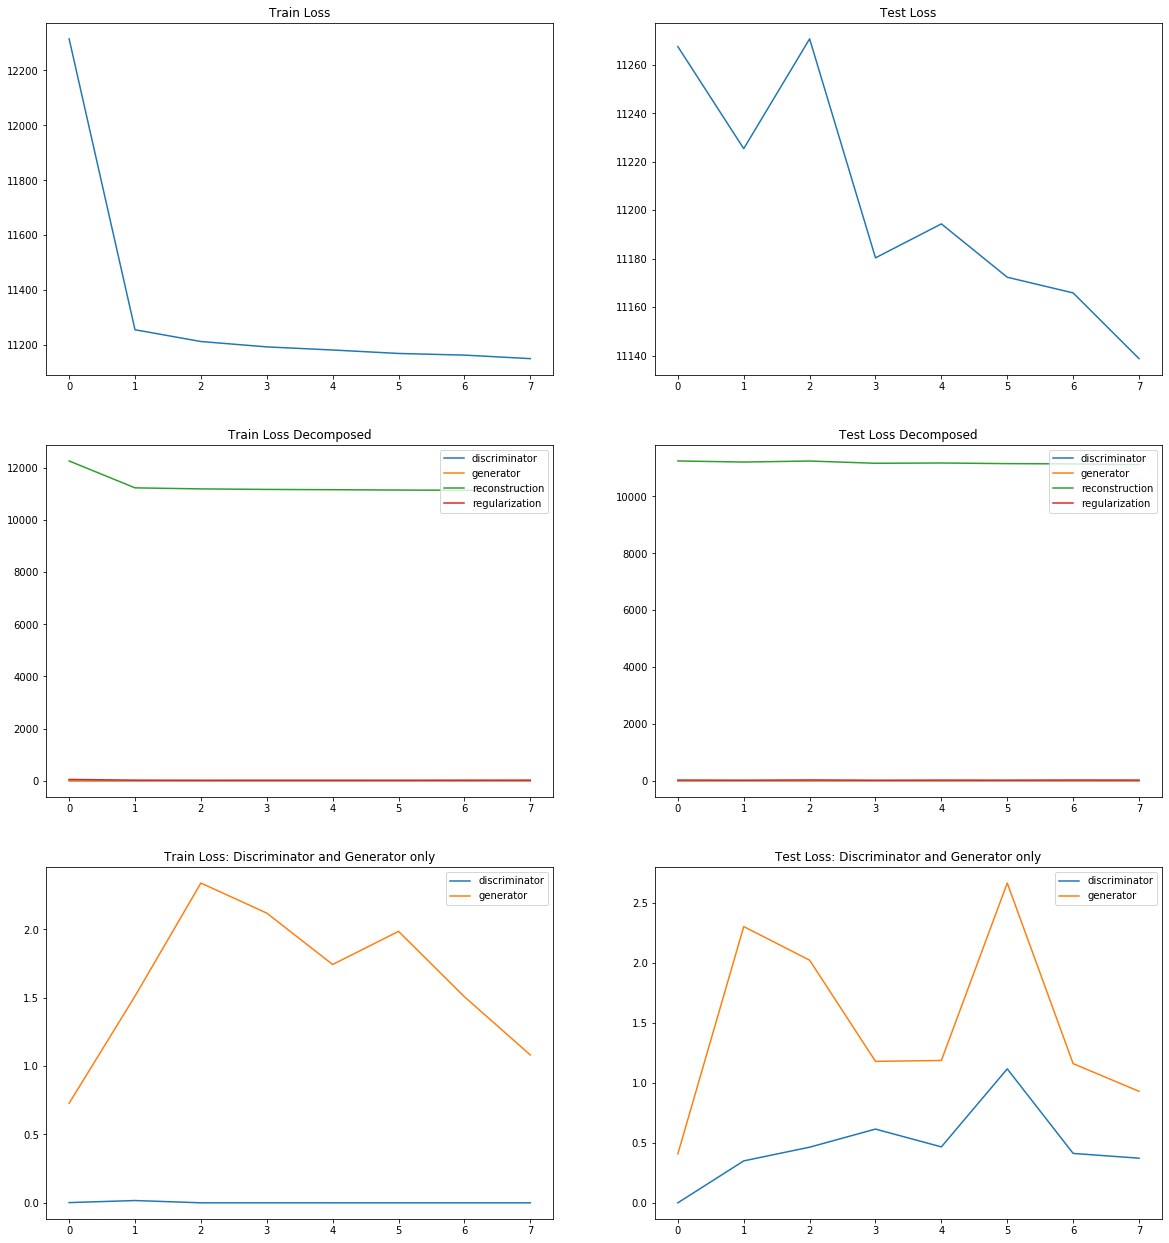

In [9]:
n_epoch = 7

loss_types = [
    'total',
    'discriminator', 'generator',
    'reconstruction', 'regularization']
train_losses = {loss_type: [] for loss_type in loss_types}
test_losses = {loss_type: [] for loss_type in loss_types}

for i in range(n_epoch+1):
    train_test = pickle.load(open(f'{OUTPUT}/training/losses/epoch_{i}.pkl', 'rb'))
    train = train_test['train']
    test = train_test['val']

    for loss_type in loss_types:
        loss = train[loss_type]
        train_losses[loss_type].append(loss)
        
        loss = test[loss_type]
        test_losses[loss_type].append(loss)

n_rows = 3
n_cols = 2
fig = plt.figure(figsize=(20, 22))

# Total
plt.subplot(n_rows, n_cols, 1)
plt.plot(train_losses['total'])
plt.title('Train Loss')

plt.subplot(n_rows, n_cols, 2)
plt.plot(test_losses['total'])
plt.title('Test Loss')

# Decomposed in sublosses
epochs = range(n_epoch+1)

plt.subplot(n_rows, n_cols, 3)
plt.plot(epochs, train_losses['discriminator'])
plt.plot(epochs, train_losses['generator'])
plt.plot(epochs, train_losses['reconstruction'])
plt.plot(epochs, train_losses['regularization'])

plt.title('Train Loss Decomposed')
plt.legend(
    [loss_type for loss_type in loss_types if loss_type != 'total'], 
    loc='upper right')

plt.subplot(n_rows, n_cols, 4)
plt.plot(epochs, test_losses['discriminator'])
plt.plot(epochs, test_losses['generator'])
plt.plot(epochs, test_losses['reconstruction'])
plt.plot(epochs, test_losses['regularization'])

plt.title('Test Loss Decomposed')
plt.legend(
    [loss_type for loss_type in loss_types if loss_type != 'total'], 
    loc='upper right')

# Only Discriminator and Generator
plt.subplot(n_rows, n_cols, 5)
plt.plot(epochs, train_losses['discriminator'])
plt.plot(epochs, train_losses['generator'])
plt.title('Train Loss: Discriminator and Generator only')
plt.legend(
    [loss_type for loss_type in loss_types 
     if loss_type == 'discriminator' or loss_type == 'generator'], 
    loc='upper right')

plt.subplot(n_rows, n_cols, 6)
plt.plot(epochs, test_losses['discriminator'])
plt.plot(epochs, test_losses['generator'])
plt.title('Test Loss: Discriminator and Generator only')
plt.legend(
    [loss_type for loss_type in loss_types 
     if loss_type == 'discriminator' or loss_type == 'generator'], 
    loc='upper right')

# 2. Inspect the latent space

In [20]:
from sklearn.decomposition import PCA
N_COMPONENTS = 2

# epoch_id = 120
# encoder = load_model('encoder', epoch_id)

encoder = vis.load_last_module(OUTPUT, 'encoder')

test = np.load('/neuro/train_val_datasets/cryo_sim.npy')

test = torch.Tensor(test)
test_dataset = torch.utils.data.TensorDataset(test)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True)

Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_16_encoder_train_loss_11117.9227_val_loss_11120.3041.pth


In [21]:
# Euclidean PCA on the Gaussian means learnt by the model
mus = []
for i, data in enumerate(test_loader):
    data = data[0].to(DEVICE)
    mu, logvar = encoder(data)
    mus.append(np.array(mu.cpu().detach()))

mus = np.array(mus).squeeze()
print(mus.shape)

pca = PCA(n_components=N_COMPONENTS)
pca.fit(mus)
print(mus.shape)
projected_mus = pca.transform(mus)
print(projected_mus.shape)

(2544, 50)
(2544, 50)
(2544, 2)


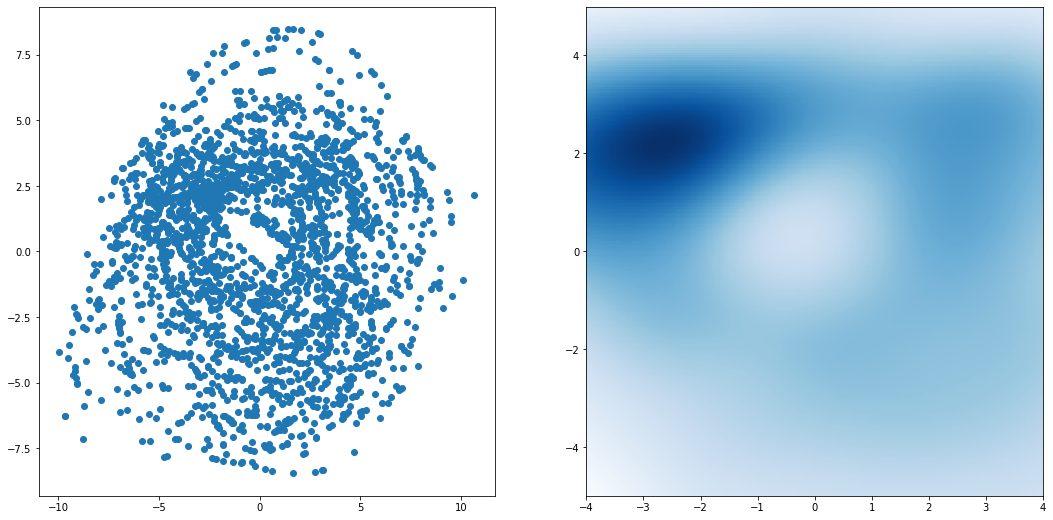

In [22]:
from scipy.stats import gaussian_kde


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
ax = axes[0]
ax.scatter(projected_mus[:, 0], projected_mus[:, 1])

ax = axes[1]

x = projected_mus[:, 0]
y = projected_mus[:, 1]
data = np.vstack([x, y])
kde = gaussian_kde(data)

# evaluate on a regular grid
xgrid = np.linspace(-4, 4, 200)
ygrid = np.linspace(-5, 5, 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

# Plot the result as an image
ax.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[-4, 4, -5, 5],
           cmap='Blues')
#cb = plt.colorbar()
#cb.set_label("density")

# for i in range(N_COMPONENTS):
#    mus = projected_mus[:,i]
#    print(np.std(mus))
#    plt.subplot(n_rows, n_cols, i+3)
#    plt.hist(mus, bins='auto')


## Standard PCA on the means of the approximation of the posterior

### Load test set and compute latent codes

In [18]:
def get_session(test_csv, test_npy):
    focuses = []

    with open(test_csv, 'r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            focuses.append(float(row))
        
    test_dataset = np.load(test_npy)
    N_PCA_COMPONENTS = 2

    # Note: the test dataset needs to be unshuffled here
    mus = analyze.latent_projection(OUTPUT, test_dataset)
    projected_mus = analyze.pca_projection(mus, N_PCA_COMPONENTS)

    return projected_mus, focuses

## Gaussian Kernel Density Estimation

In [14]:
FOCUS_MAX = 500

TASK_TO_MARKER = {
    'rest': 'o',
    'breathhold': 'x',
    'dotstop': 'triangle_down',
    'eyesopen': 'star',
    'languagewm': 'tri_down',
    'nback': 'triangle_left',
    'objects': 'hexagon1',
    'retinotopy': 'plus',
    'spatialwm': 'diamond'
}

colormap = cm.get_cmap('viridis')
COLORS = colormap(np.linspace(0, 1., FOCUS_MAX))

def plot_session(ax, test_csv, ses_id):
    projected_mus, focuses = get_session(test_csv, test_npy)

    for mu, focus in zip(projected_mus, focuses):
        ax.scatter(mu[0], mu[1], c=np.array([COLORS[focus]]), s=1)
    return ax

Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth
Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss

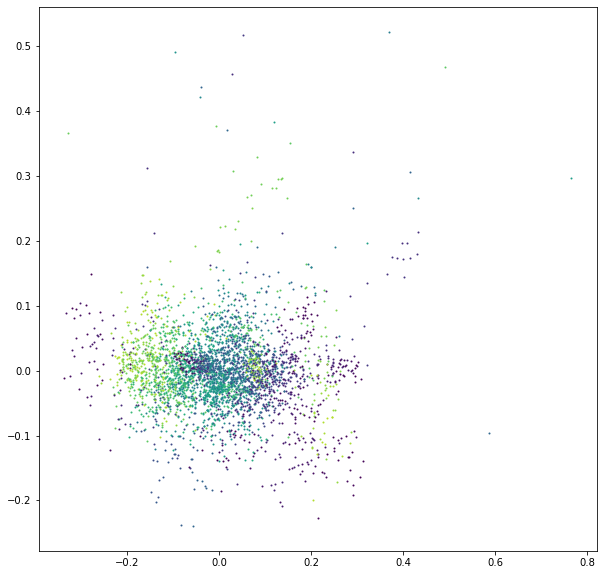

In [15]:
csv_path = '/neuro/train_val_datasets/cryo_sim_labels.csv'
npy_path = '/neuro/train_val_datasets/cryo_sim.npy'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

plot_session(ax, csv_path, npy_path)

Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_19_encoder_train_loss_5893.4182_val_loss_11365.7494.pth


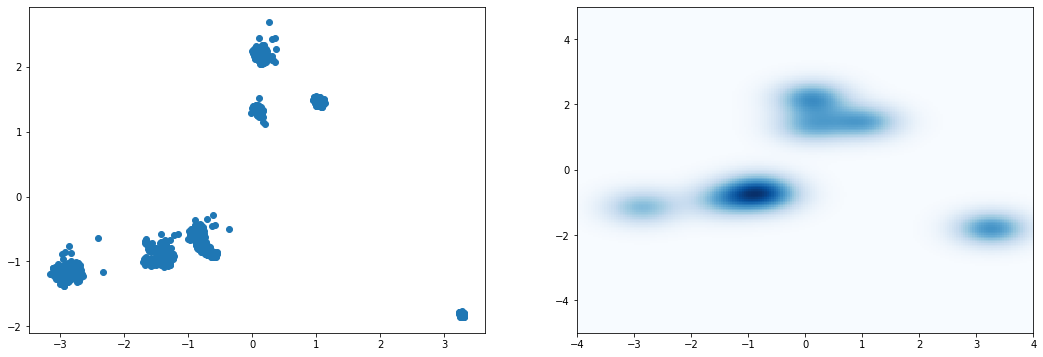

In [19]:
from scipy.stats import gaussian_kde

train_csv_path = '/neuro/train_val_datasets/train_fmri_128x128_labels.csv'
projected_mus, tasks, times = get_session(train_csv_path, ses_id='all')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

ax = axes[0]
ax.scatter(projected_mus[:, 0], projected_mus[:, 1])

ax = axes[1]
ax = analyze.plot_kde(ax, projected_mus)
#cb = plt.colorbar()
#cb.set_label("density")

# for i in range(N_COMPONENTS):
#    mus = projected_mus[:,i]
#    print(np.std(mus))
#    plt.subplot(n_rows, n_cols, i+3)
#    plt.hist(mus, bins='auto')


## Fit a Gaussian Mixture

INFO:root:Found 106 sessions of rfMRIs: Divide in 75 train, 21 val and 10 test sessions

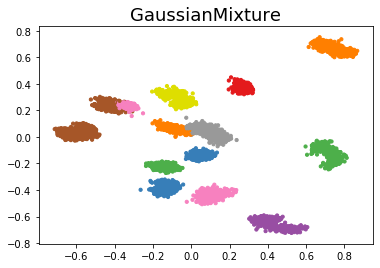

In [31]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

# Clustering
X = projected_mus
n_components = 13

#X = StandardScaler().fit_transform(X)
gmm = mixture.GaussianMixture(
    n_components=n_components, covariance_type='full')
algorithm = gmm
name = 'GaussianMixture'
    
algorithm.fit(X)

if hasattr(algorithm, 'labels_'):
    print('test')
    y_pred = algorithm.labels_.astype(np.int)
else:
    y_pred = algorithm.predict(X)

fig, ax = plt.subplots(1, 1)
ax.set_title(name, size=18)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                      '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
ax.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

#ax.xlim(-4, 4)
#ax.ylim(-5, 5)
#ax.xticks(())
#ax.yticks(())

plt.show()

### Interactive exploration of PCA in each cluster

In [26]:
print(torch.__version__)

1.1.0


In [35]:
epoch_id = 19

stds = np.zeros(N_COMPONENTS)
for i in range(N_COMPONENTS):
    stds[i] = np.std(projected_mus[:,i])
    
decoder = vis.load_module(OUTPUT, 'decoder', epoch_id)


projected = {}
pcas = {}
for i in range(n_components):
    print('Cluster: %d' % i)
    cluster = mus[y_pred==i]
    pca = PCA(n_components=N_COMPONENTS)
    pca.fit(cluster)
    projected[i] = pca.transform(cluster)
    pcas[i] = pca

    @interact(
        c1=FloatSlider(min=-3,max=3,step=0.1,value=0), 
        c2=FloatSlider(min=-3,max=3,step=0.1,value=0),
        c3=FloatSlider(min=-3,max=3,step=0.1,value=0),
        c4=FloatSlider(min=-3,max=3,step=0.1,value=0),
        c5=FloatSlider(min=-3,max=3,step=0.1,value=0))
    def display_image(c1, c2, c3, c4, c5):
        z = (c1 * pca.components_[0]
             + c2 * pca.components_[1]
             + c3 * pca.components_[2]
             + c4 * pca.components_[3]
             + c5 * pca.components_[4])
        z = torch.Tensor(z).cuda()
        recon, _ = decoder(z)
        recon = recon.squeeze()
        plt.imshow(recon.detach().cpu(), cmap='gray')

Loading: /scratch/users/nmiolane/output/training/models/epoch_19_decoder_train_loss_5893.4182_val_loss_11365.7494.pth
Cluster: 0


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 1


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 2


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 3


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 4


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 5


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 6


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 7


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 8


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 9


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 10


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 11


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 12


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

### PCA in each cluster

In [34]:
fig = plt.figure(figsize=(20, 50))
plt.tight_layout()
r = 4
n_cols = 2 * r + 1 

projected = {}
pcas = {}
cmaps = ['Blues', 'Purples', 'Greens', 'Oranges', 'Reds']
for i in range(n_clusters):
    cluster = mus[y_pred==i]
    pca = PCA(n_components=N_COMPONENTS)
    pca.fit(cluster)
    projected[i] = pca.transform(cluster)
    pcas[i] = pca

    for id in range(N_COMPONENTS):
        for slider in range(-r, r+1, 1):
            plt.subplot(n_clusters*N_COMPONENTS, n_cols, i * N_COMPONENTS * n_cols + id * n_cols + slider + r + 1)
            z = slider * pca.components_[id]
            z = torch.Tensor(z).cuda()
            recon, _ = decoder(z)
            recon = recon.squeeze()
            plt.imshow(recon.detach().cpu(), cmap=cmaps[i])

NameError: name 'n_clusters' is not defined

<Figure size 1440x3600 with 0 Axes>

# 3. Inspect report created by pipeline

In [49]:
import os
import pylab

report_dir = '/scratch/users/nmiolane/output/report'
losses_path = os.path.join(report_dir, 'losses.png')
images_path = os.path.join(report_dir, 'images.png')
report_path = os.path.join(report_dir, 'report.html')

plt.figure()
img = pylab.imread(losses_path)
plt.imshow(img, aspect='auto')
plt.axis('off')

plt.figure(figsize=(30, 60))
img = pylab.imread(images_path)
plt.imshow(img)
plt.axis('off')


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/users/nmiolane/output/report/losses.png'

<Figure size 432x288 with 0 Axes>

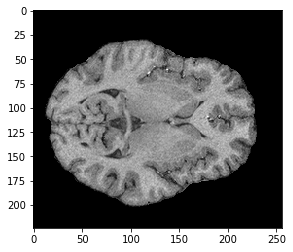

In [3]:
import nibabel
path = '/tmp/_oyiw_36_defBrainExtractionBrain.nii.gz'
img = nibabel.load(path)
array = img.get_fdata()
array = np.nan_to_num(array)
plt.imshow(array[:,:,120], cmap='gray')